# population-zscore
notebook for calculating the z-scores of the posterior samples returned for each hare

In [1]:
#stock imports
import numpy as np
import pandas as pd
import json
import pickle
import scipy
import os
##plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import corner

# plt.style.use('dark_background')
plt.style.use("Solarize_Light2")
plt.rcParams.update({"axes.edgecolor": "black"})
plt.rcParams.update({"text.color": "black"})
plt.rcParams.update({"axes.labelcolor": "black"})
plt.rcParams.update({"xtick.color": "black"})
plt.rcParams.update({"ytick.color": "black"})
plt.rcParams.update({"font.family": "monospace"})

#.script imports
from scripts import prior_funcs, utils

In [26]:
z_scores_dict = {}
for obs_idx in range(2):
    z_scores_dict[f'obs{obs_idx}'] = {}
    zscore_upper_array=np.empty((0,7))
    zscore_mean_array=np.empty((0,7))
    zscore_lower_array=np.empty((0,7))
    for hare_idx in range(6):
        path = f'form/hare{hare_idx}/obs{obs_idx}/'
        
        with open(path+'samples.pkl', 'rb') as fp:
             samples = pickle.load(fp)
        
        samples = samples['samples']
        
        inputs = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']
        samples_df = pd.DataFrame(samples, columns = inputs)
        
        hare_df = pd.read_json(path+f'obs{obs_idx}.json')[inputs]
        
        zscore_upper_row = np.empty(7)
        zscore_mean_row = np.empty(7)
        zscore_lower_row = np.empty(7)
        
        array_idx = 0
        for label in inputs:
            samples_label = samples_df[label]
            hare_label = hare_df[label]
        
            samples_std = samples_label.std()
            
            zscore_dist = (hare_label.values[0] - samples_label)/samples_std
        
            zscore_upper_row[array_idx] = zscore_dist.mean() + zscore_dist.std()

            zscore_mean_row[array_idx] = zscore_dist.mean()
    
            zscore_lower_row[array_idx] = zscore_dist.mean() - zscore_dist.std()
        
            array_idx+=1
    
        zscore_upper_array = np.vstack([zscore_upper_array, zscore_upper_row])
        zscore_mean_array = np.vstack([zscore_mean_array, zscore_mean_row])
        zscore_lower_array = np.vstack([zscore_lower_array, zscore_lower_row])
    
    z_scores_dict[f'obs{obs_idx}']['zscore_upper_df'] = pd.DataFrame(zscore_upper_array, columns = inputs)
    z_scores_dict[f'obs{obs_idx}']['zscore_mean_df'] = pd.DataFrame(zscore_mean_array, columns = inputs)
    z_scores_dict[f'obs{obs_idx}']['zscore_lower_df'] = pd.DataFrame(zscore_lower_array, columns = inputs)


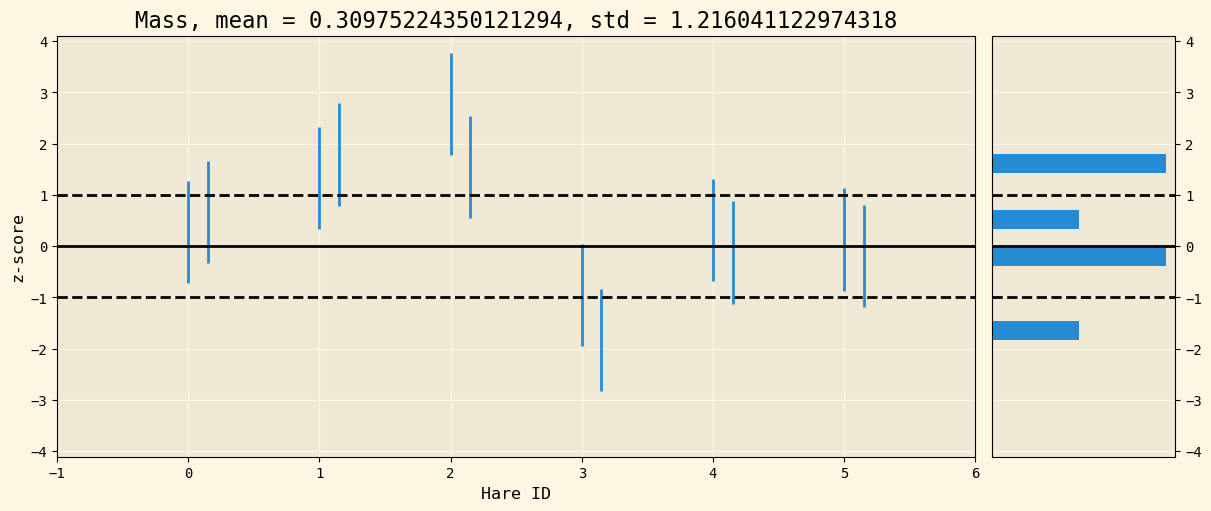

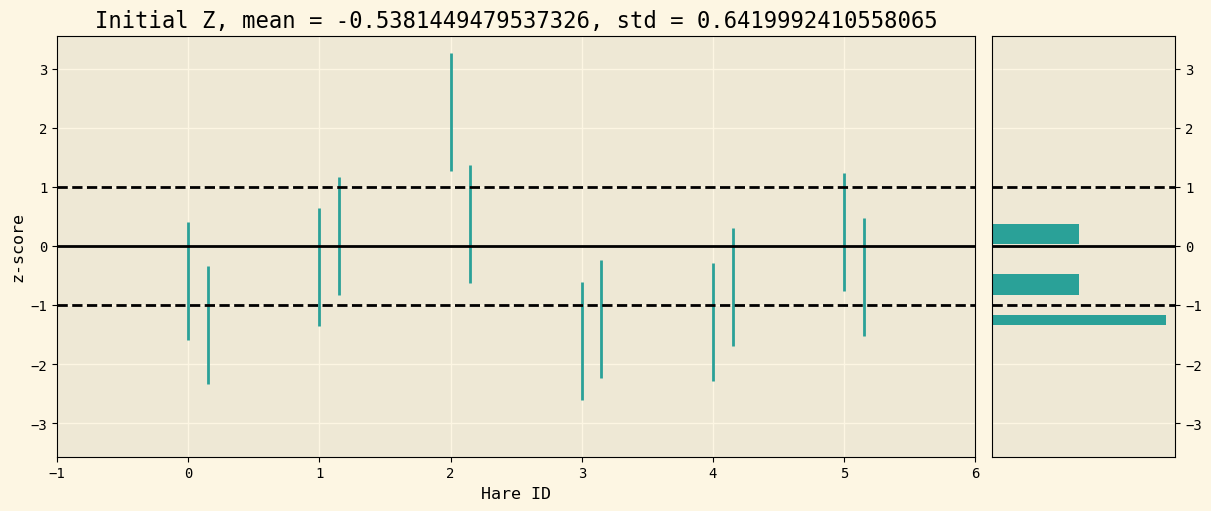

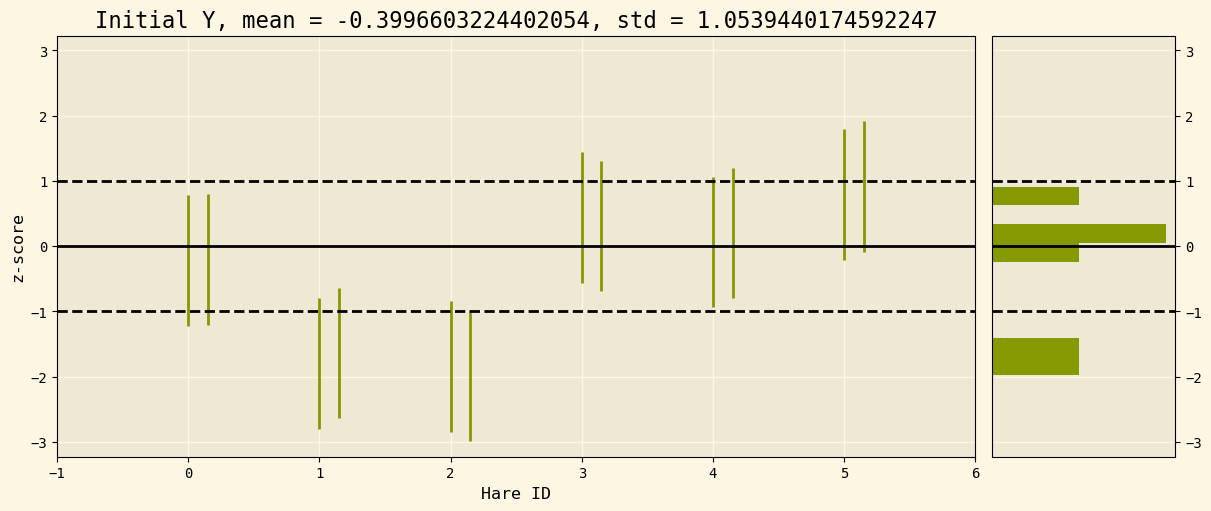

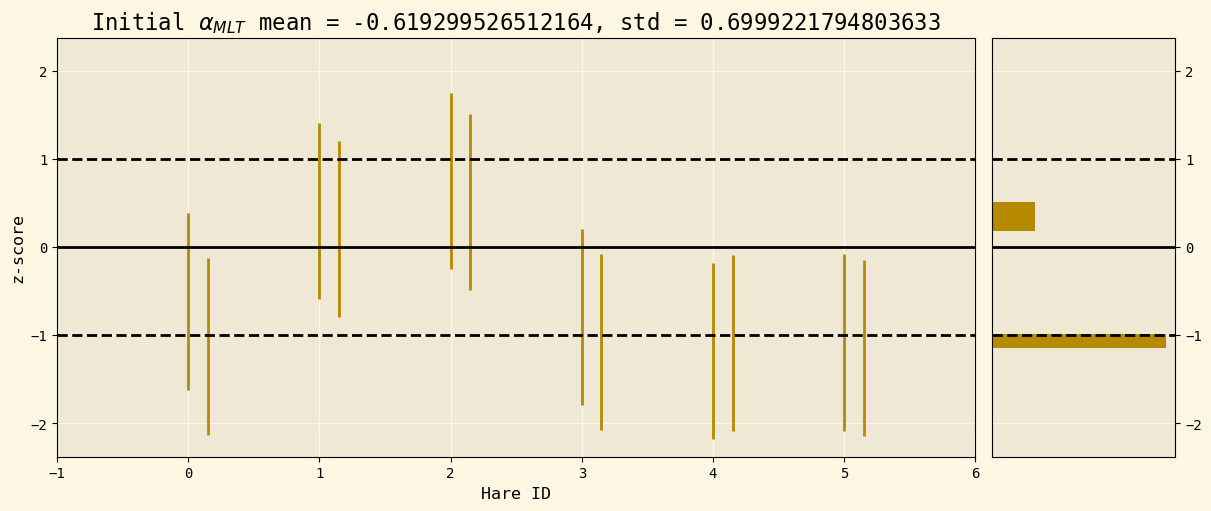

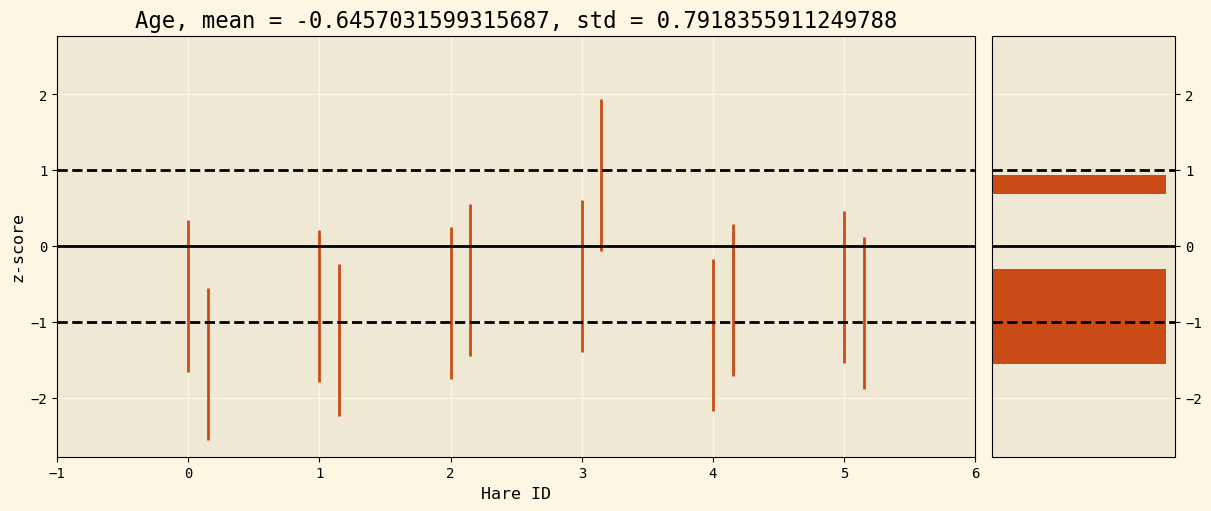

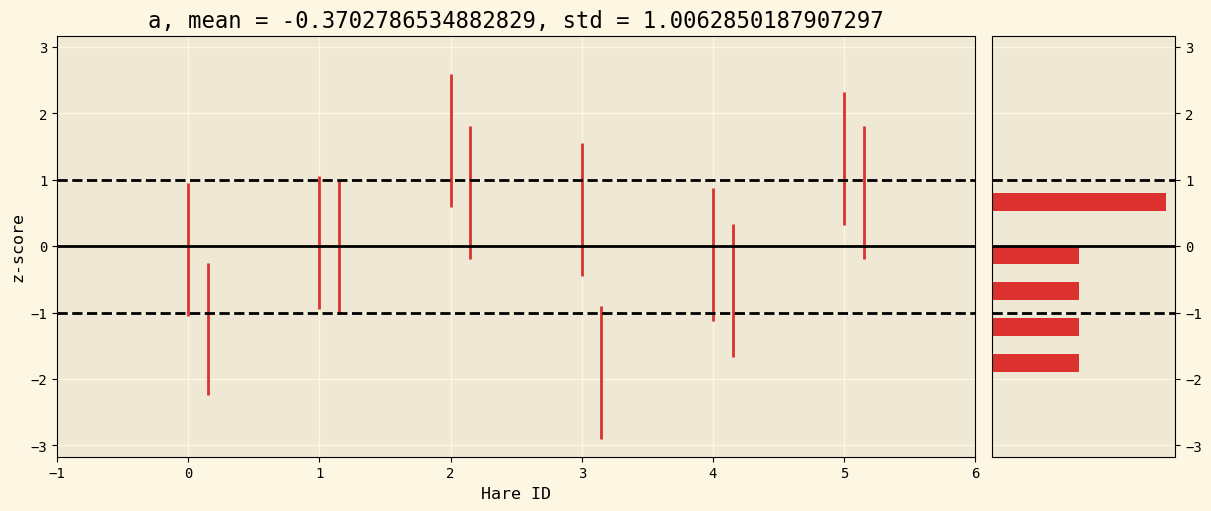

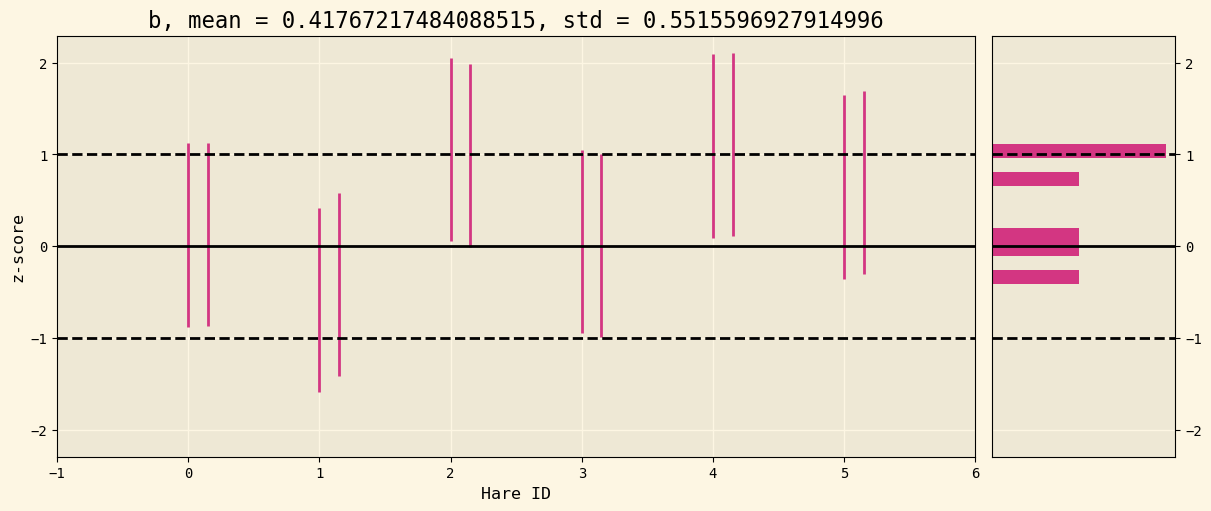

In [28]:
#colors = ['r', 'b', 'g', 'c', 'm']
colours = [colour["color"] for colour in plt.rcParams["axes.prop_cycle"]]

hares_observed=6
label_idx = 0
for label in inputs:
    fig, (ax,ax1) = plt.subplots(1,2, figsize=(12,5), width_ratios=(5,1), layout='compressed')
    z_score_means_array = np.array([])
    for obs_idx in range(2):
        zscore_lower_df = z_scores_dict[f'obs{obs_idx}']['zscore_lower_df']
        zscore_mean_df = z_scores_dict[f'obs{obs_idx}']['zscore_mean_df']
        zscore_upper_df = z_scores_dict[f'obs{obs_idx}']['zscore_upper_df']

        z_score_means_array = np.concatenate((z_score_means_array,zscore_mean_df[label].values))
        for i in range(hares_observed):
            x_val = i+(obs_idx*0.15)
            ax.plot(np.full(2, x_val), np.array([zscore_lower_df[label].values[i], zscore_upper_df[label].values[i]]), c=colours[label_idx])

        
    ax.axhline(0, c='black')
    ax.axhline(-1, c='black', linestyle='--')
    ax.axhline(1, c='black', linestyle='--')
    
    yabs_max = abs(max(ax.get_ylim(), key=abs))
    ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
    ax.set_xlim(xmin=-1, xmax=hares_observed)


    ax1.hist(zscore_mean_df[label].values, orientation='horizontal', density=False, color=colours[label_idx], bins=10)
    ax1.yaxis.tick_right()

    ax1.axhline(0, c='black')
    ax1.axhline(-1, c='black', linestyle='--')
    ax1.axhline(1, c='black', linestyle='--')
    ax1.set_xticks([])
    ax1.set_ylim(ymin=-yabs_max, ymax=yabs_max)

    mean = zscore_mean_df[label].values.mean()
    std = zscore_mean_df[label].values.std()
    
    if label == "initial_mass":
        ax.set_title(rf"Mass, mean = {mean}, std = {std}")

    elif label == "initial_Zinit":
        ax.set_title(f"Initial Z, mean = {mean}, std = {std}")

    elif label == "initial_Yinit":
        ax.set_title(f"Initial Y, mean = {mean}, std = {std}")

    elif label == "initial_MLT":
        ax.set_title(r"Initial $\alpha_{MLT}$"+f" mean = {mean}, std = {std}")

    elif label == "star_age":
        ax.set_title(f"Age, mean = {mean}, std = {std}")

    elif label == "a":
        ax.set_title(f"a, mean = {mean}, std = {std}")

    elif label == "b":
        ax.set_title(f"b, mean = {mean}, std = {std}")

    ax.set_xlabel("Hare ID")

    ax.set_ylabel("z-score")
    label_idx+=1

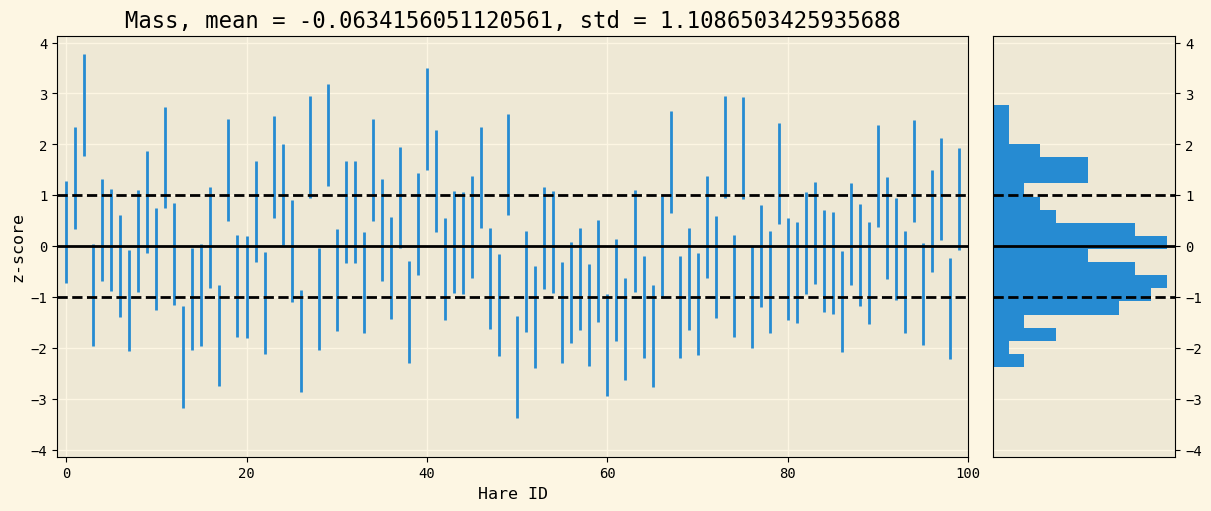

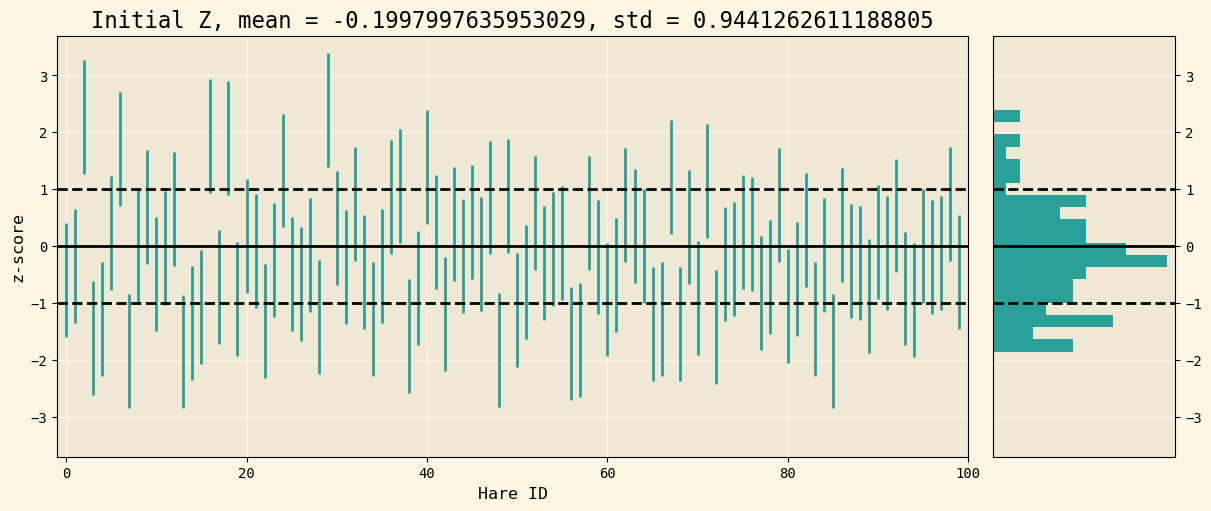

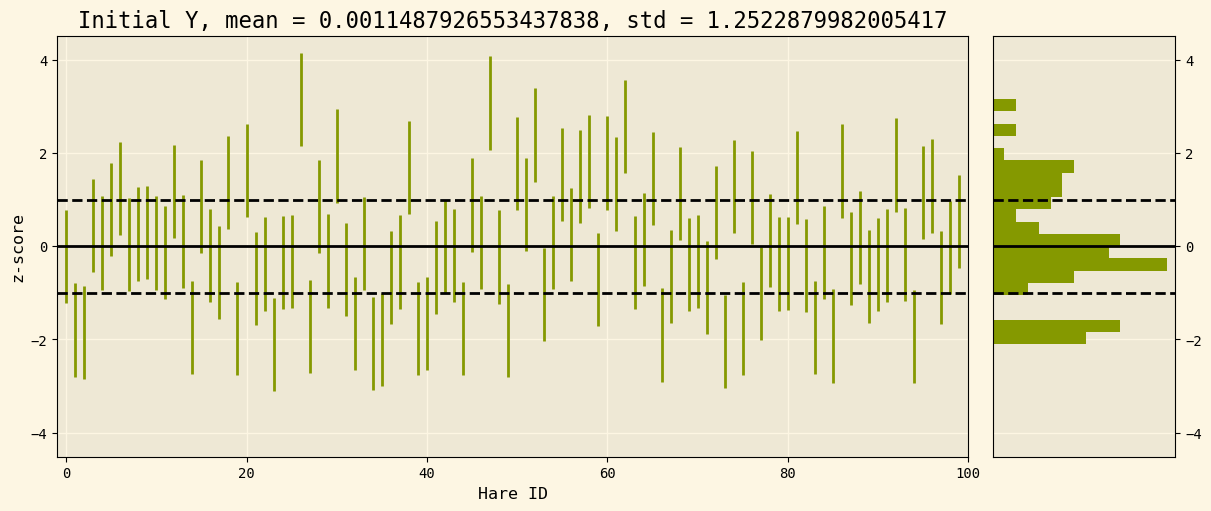

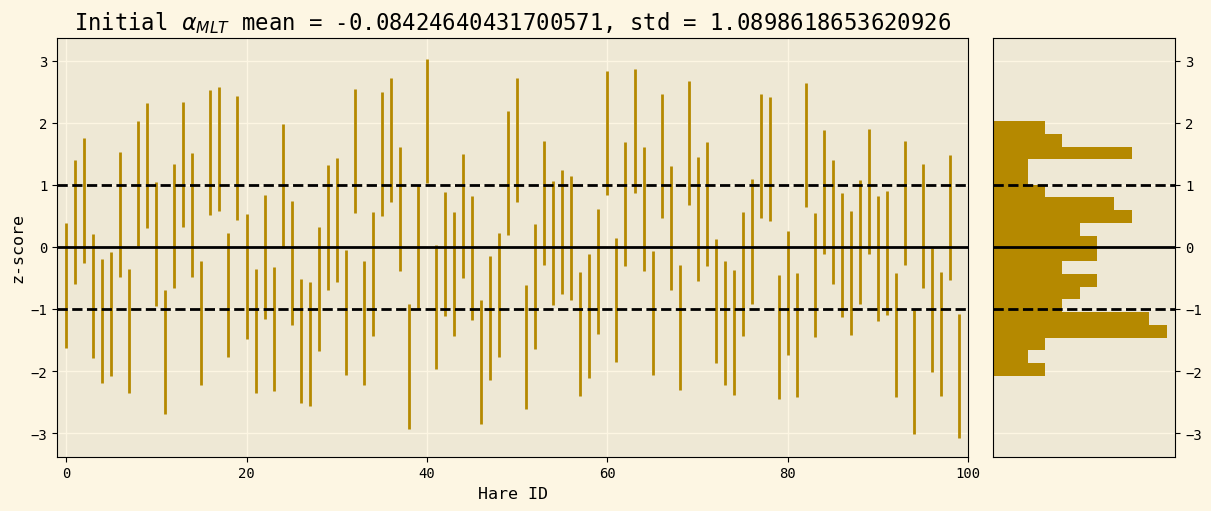

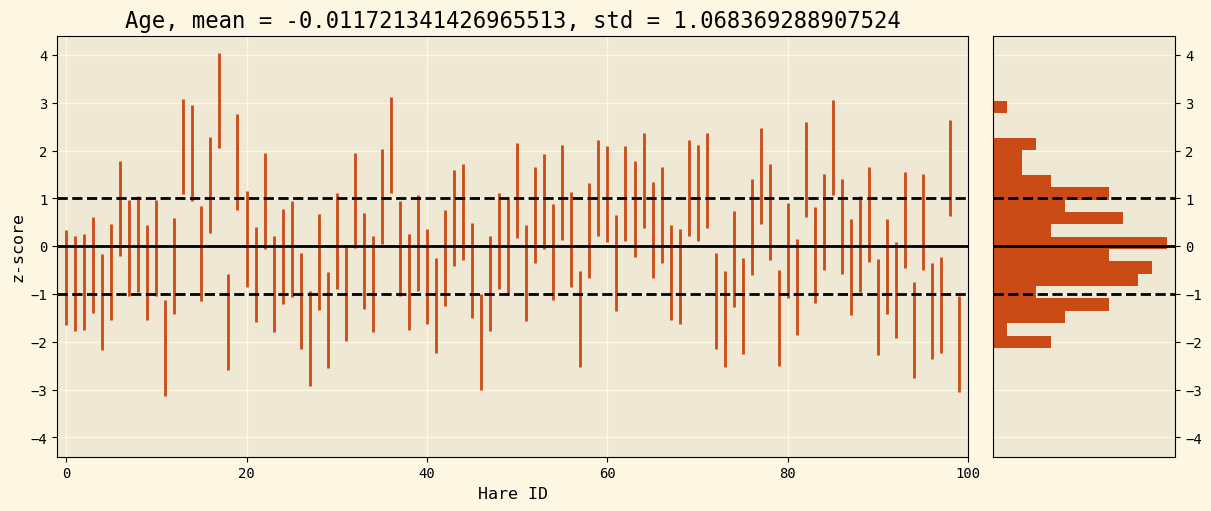

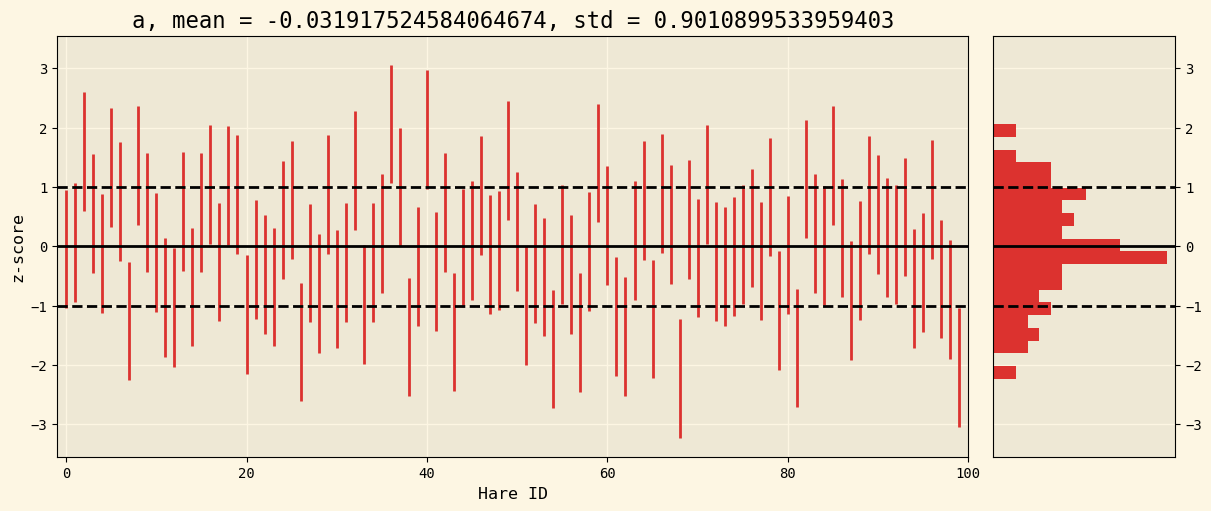

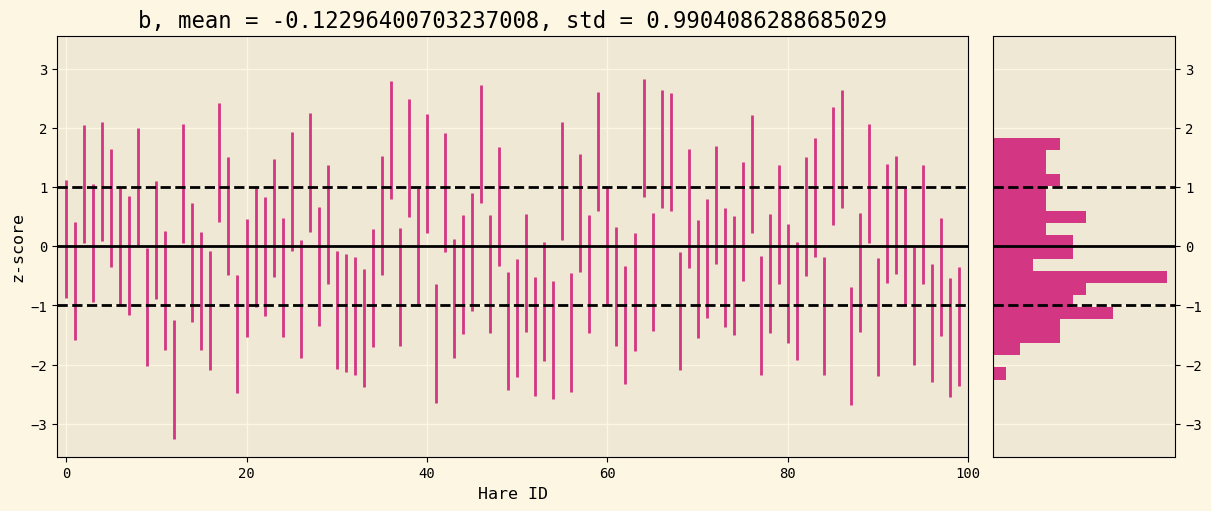

In [21]:
#colors = ['r', 'b', 'g', 'c', 'm']
colours = [colour["color"] for colour in plt.rcParams["axes.prop_cycle"]]

hares_observed=100
label_idx = 0
for label in inputs:
    fig, (ax,ax1) = plt.subplots(1,2, figsize=(12,5), width_ratios=(5,1), layout='compressed')
    observations = 1
    #z_score_means_array = np.zeros(observations*hares_observed)
    for obs_idx in range(observations):
        zscore_lower_df = z_scores_dict[f'obs{obs_idx}']['zscore_lower_df']
        zscore_mean_df = z_scores_dict[f'obs{obs_idx}']['zscore_mean_df']
        zscore_upper_df = z_scores_dict[f'obs{obs_idx}']['zscore_upper_df']
        for i in range(hares_observed):
            x_val = i+(obs_idx*0.15)
            ax.plot(np.full(2, x_val), np.array([zscore_lower_df[label].values[i], zscore_upper_df[label].values[i]]), c=colours[label_idx])

        
    ax.axhline(0, c='black')
    ax.axhline(-1, c='black', linestyle='--')
    ax.axhline(1, c='black', linestyle='--')
    
    yabs_max = abs(max(ax.get_ylim(), key=abs))
    ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
    ax.set_xlim(xmin=-1, xmax=hares_observed)


    ax1.hist(zscore_mean_df[label].values, orientation='horizontal', density=False, color=colours[label_idx], bins=20)
    ax1.yaxis.tick_right()

    ax1.axhline(0, c='black')
    ax1.axhline(-1, c='black', linestyle='--')
    ax1.axhline(1, c='black', linestyle='--')
    ax1.set_xticks([])
    ax1.set_ylim(ymin=-yabs_max, ymax=yabs_max)

    mean = zscore_mean_df[label].values.mean()
    std = zscore_mean_df[label].values.std()
    
    if label == "initial_mass":
        ax.set_title(rf"Mass, mean = {mean}, std = {std}")

    elif label == "initial_Zinit":
        ax.set_title(f"Initial Z, mean = {mean}, std = {std}")

    elif label == "initial_Yinit":
        ax.set_title(f"Initial Y, mean = {mean}, std = {std}")

    elif label == "initial_MLT":
        ax.set_title(r"Initial $\alpha_{MLT}$"+f" mean = {mean}, std = {std}")

    elif label == "star_age":
        ax.set_title(f"Age, mean = {mean}, std = {std}")

    elif label == "a":
        ax.set_title(f"a, mean = {mean}, std = {std}")

    elif label == "b":
        ax.set_title(f"b, mean = {mean}, std = {std}")

    ax.set_xlabel("Hare ID")

    ax.set_ylabel("z-score")
    label_idx+=1

In [ ]:
zscore_mean_df.describe()

In [18]:
zscore_mean_df

,initial_mass,initial_Zinit,initial_Yinit,initial_MLT,star_age,a,b
0,0.669058,-1.330205,-0.206002,-1.127043,-1.548793,-1.24665,0.128664
